## Nesecary libararies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import product

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")  # Suppress convergence warnings

## Data Exploration

In [2]:
# Load CSV, parse timestamp as datetime, set as time index
df = pd.read_csv("Exam.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp").sort_index()

In [3]:
# Quick shape check
print("Rows:", len(df), " Columns:", df.shape[1])

Rows: 35064  Columns: 5


In [4]:
# Preview first rows
df

,load_MW,temp_C,price_DA_EUR_MWh,solar_MW,clouds_pct
timestamp,,,,,
2014-12-31 23:00:00+00:00,25385.0,-2.675,50.10,49.0,0
2015-01-01 00:00:00+00:00,24382.0,-2.675,48.10,50.0,0
2015-01-01 01:00:00+00:00,22734.0,-3.464,47.33,50.0,0
2015-01-01 02:00:00+00:00,21286.0,-3.464,42.27,50.0,0
2015-01-01 03:00:00+00:00,20264.0,-3.464,38.41,42.0,0
...,...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,12.490,68.85,85.0,0
2018-12-31 19:00:00+00:00,29735.0,9.990,68.40,33.0,0
2018-12-31 20:00:00+00:00,28071.0,8.510,66.88,31.0,0


In [5]:
# Inspect data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   load_MW           35028 non-null  float64
 1   temp_C            35064 non-null  float64
 2   price_DA_EUR_MWh  35064 non-null  float64
 3   solar_MW          35046 non-null  float64
 4   clouds_pct        35064 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.6 MB


In [6]:
# Summary statistics for each column
df.describe()

,load_MW,temp_C,price_DA_EUR_MWh,solar_MW,clouds_pct
count,35028.000000,35064.000000,35064.000000,35046.000000,35064.000000
mean,28696.939905,17.633954,49.874341,1432.665925,20.740475
std,4574.987950,7.234569,14.618900,1680.119887,25.604016
min,18041.000000,-4.319344,2.060000,0.000000,0.000000
25%,24807.750000,12.000000,41.490000,71.000000,0.000000
50%,28901.000000,17.040000,50.520000,616.000000,20.000000
75%,32192.000000,23.000000,60.530000,2578.000000,20.000000
max,41015.000000,38.000000,101.990000,5792.000000,100.000000


In [7]:
# Time-index diagnostics and quick sanity checks

# Date range and index properties
print("Index dtype:", df.index.dtype)
print("Index timezone:", getattr(df.index, "tz", None))
print("Date range:", df.index.min(), "to", df.index.max())
print("Number of rows:", len(df))
print("Columns:", list(df.columns))

Index dtype: datetime64[ns, UTC]
Index timezone: UTC
Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Number of rows: 35064
Columns: ['load_MW', 'temp_C', 'price_DA_EUR_MWh', 'solar_MW', 'clouds_pct']


In [8]:
# Check index monotonicity and hourly continuity
print("Index is monotonic increasing:", df.index.is_monotonic_increasing)

expected_hourly = pd.date_range(df.index.min(), df.index.max(), freq="H", tz=df.index.tz)
missing_timestamps = expected_hourly.difference(df.index)

print("Duplicate timestamps:", df.index.duplicated().sum())
print("Missing hourly timestamps:", len(missing_timestamps))
if len(missing_timestamps) > 0:
    print("First 10 missing:", missing_timestamps[:10])

Index is monotonic increasing: True
Duplicate timestamps: 0
Missing hourly timestamps: 0


In [9]:
# Largest gap between consecutive timestamps
max_gap = df.index.to_series().diff().max()
print("Largest gap between rows:", max_gap)

Largest gap between rows: 0 days 01:00:00


In [10]:
# Quick extremes for key variables
for col in ["load_MW", "temp_C", "price_DA_EUR_MWh", "solar_MW", "clouds_pct"]:
    col_min = df[col].min()
    col_max = df[col].max()
    col_mean = df[col].mean()
    col_median = df[col].median()
    print(f"{col}: min={col_min}, max={col_max}, mean={col_mean:.2f}, median={col_median:.2f}")

load_MW: min=18041.0, max=41015.0, mean=28696.94, median=28901.00
temp_C: min=-4.319343749999973, max=38.0, mean=17.63, median=17.04
price_DA_EUR_MWh: min=2.06, max=101.99, mean=49.87, median=50.52
solar_MW: min=0.0, max=5792.0, mean=1432.67, median=616.00
clouds_pct: min=0, max=100, mean=20.74, median=20.00


## Data Cleaning and Exploration

In [11]:
# Ensure numeric dtypes and sorted datetime index
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")
print(df.dtypes)

print("Index is DatetimeIndex:", isinstance(df.index, pd.DatetimeIndex))
df = df.sort_index()
print("Sorted by datetime:", df.index.is_monotonic_increasing)

load_MW             float64
temp_C              float64
price_DA_EUR_MWh    float64
solar_MW            float64
clouds_pct            int64
dtype: object
Index is DatetimeIndex: True
Sorted by datetime: True


In [12]:
# Missing values check
missing_before = df.isna().sum()
print("Missing values before:", missing_before.to_dict())

Missing values before: {'load_MW': 36, 'temp_C': 0, 'price_DA_EUR_MWh': 0, 'solar_MW': 18, 'clouds_pct': 0}


In [13]:
# Impute missing values: interpolate over time, then forward/back fill
before = df.isna().sum()
df_interp = df.interpolate(method="time")
after_interp = df_interp.isna().sum()
filled_interp = (before - after_interp).to_dict()

df_filled = df_interp.ffill().bfill()
after_fill = df_filled.isna().sum()
filled_fill = (after_interp - after_fill).to_dict()

# assign back to df
df = df_filled

print("Filled by interpolation:", {k: int(v) for k, v in filled_interp.items()})
print("Filled by ffill/bfill:", {k: int(v) for k, v in filled_fill.items()})
print("Missing after fill:", after_fill.to_dict())


Filled by interpolation: {'load_MW': 36, 'temp_C': 0, 'price_DA_EUR_MWh': 0, 'solar_MW': 18, 'clouds_pct': 0}
Filled by ffill/bfill: {'load_MW': 0, 'temp_C': 0, 'price_DA_EUR_MWh': 0, 'solar_MW': 0, 'clouds_pct': 0}
Missing after fill: {'load_MW': 0, 'temp_C': 0, 'price_DA_EUR_MWh': 0, 'solar_MW': 0, 'clouds_pct': 0}


In [14]:
# Duplicate timestamps check
dup_count = df.index.duplicated().sum()
print("Duplicate timestamps:", int(dup_count))
if dup_count > 0:
    df = df[~df.index.duplicated(keep="first")]
    print("Duplicates removed. New rows:", len(df))


Duplicate timestamps: 0


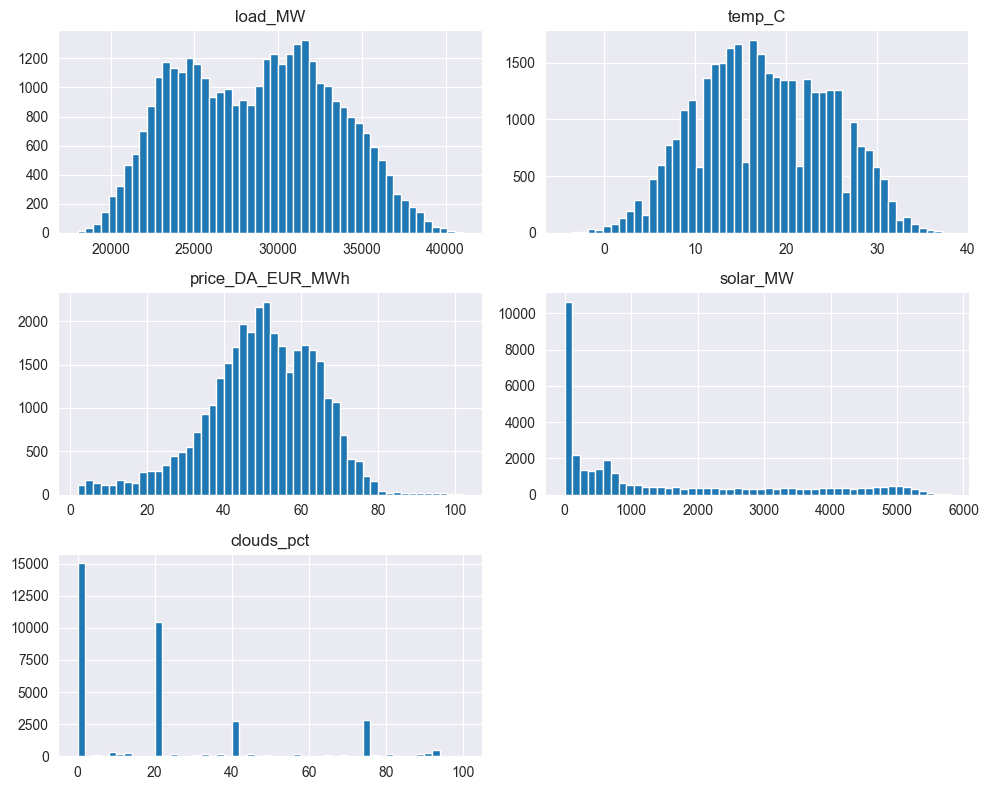

In [15]:
# Plot histograms for each numeric column
df.hist(bins=50, figsize=(10, 8))
plt.tight_layout()
plt.show()

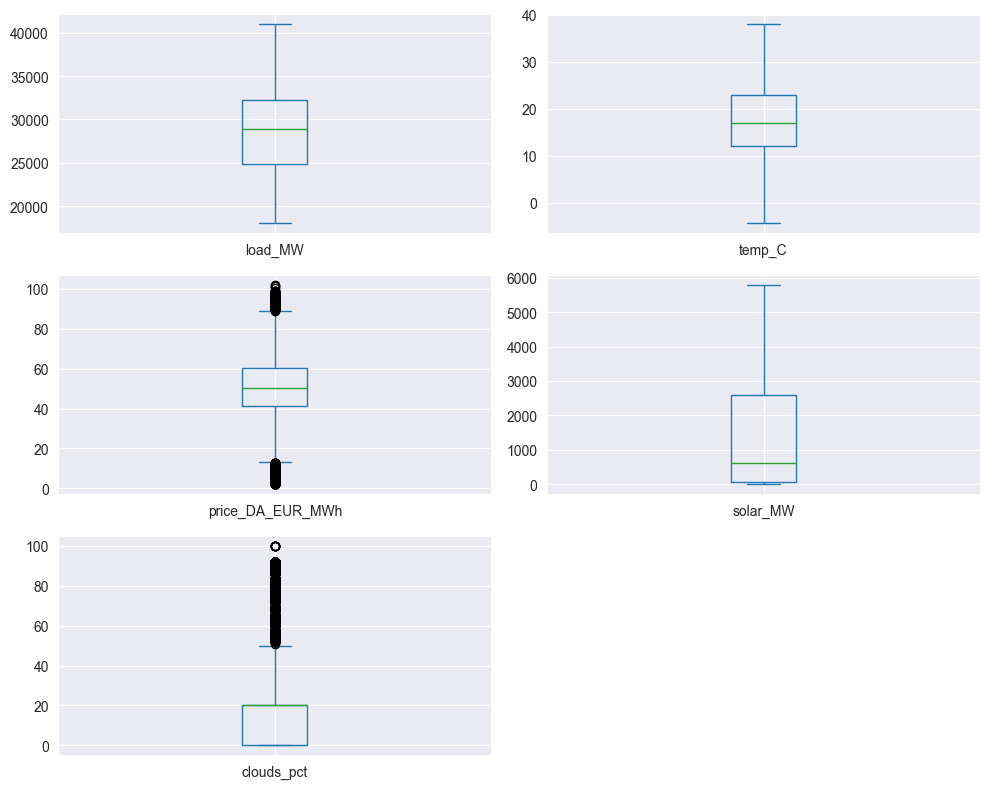

In [16]:
# Plot boxplots for each numeric column
df.plot(kind="box", subplots=True, layout=(3, 2), figsize=(10, 8), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

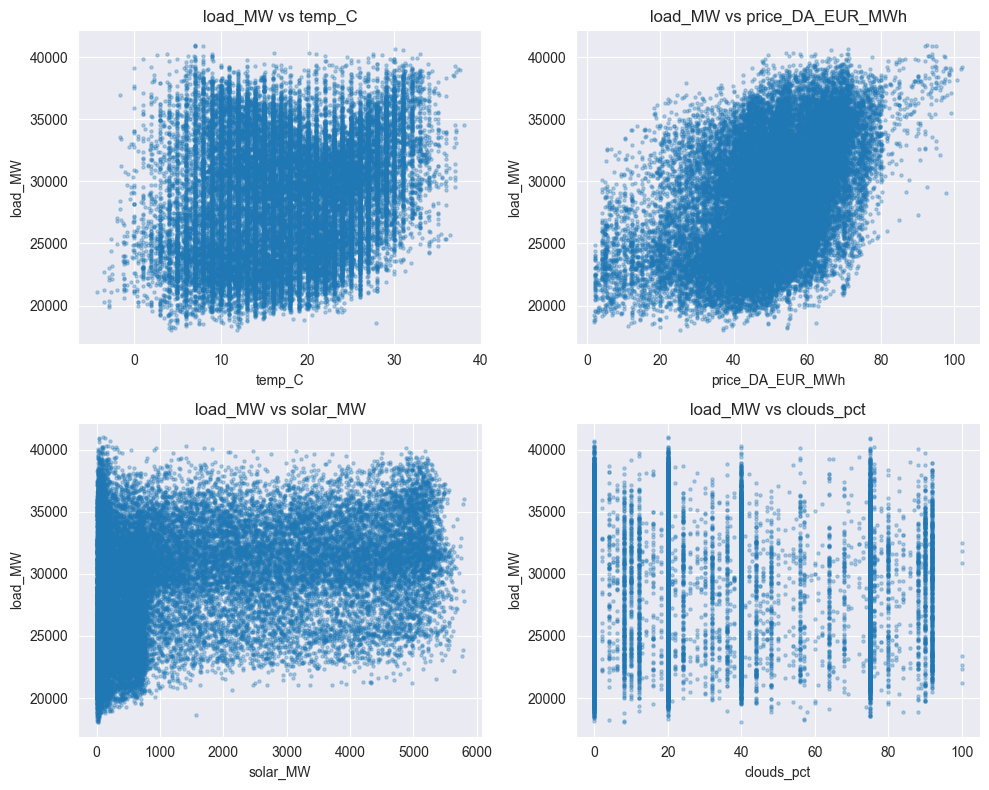

In [17]:
# Scatter plots: predictors vs load_MW
predictors = ["temp_C", "price_DA_EUR_MWh", "solar_MW", "clouds_pct"]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for ax, col in zip(axes, predictors):
    ax.scatter(df[col], df["load_MW"], alpha=0.3, s=5)
    ax.set_xlabel(col)
    ax.set_ylabel("load_MW")
    ax.set_title(f"load_MW vs {col}")
plt.tight_layout()
plt.show()

In [18]:
# Detect and handle impossible values, then refill
changes = {}

# clouds_pct should be in [0, 100]
mask_clouds = (df["clouds_pct"] < 0) | (df["clouds_pct"] > 100)
changes["clouds_pct_outside_0_100"] = int(mask_clouds.sum())
df.loc[mask_clouds, "clouds_pct"] = np.nan

# temp_C plausible range [-50, 60]
mask_temp = (df["temp_C"] < -50) | (df["temp_C"] > 60)
changes["temp_C_outside_plausible"] = int(mask_temp.sum())
df.loc[mask_temp, "temp_C"] = np.nan

# solar_MW should not be negative
mask_solar = df["solar_MW"] < 0
changes["solar_MW_negative"] = int(mask_solar.sum())
df.loc[mask_solar, "solar_MW"] = np.nan

# load_MW should not be negative
mask_load = df["load_MW"] < 0
changes["load_MW_negative"] = int(mask_load.sum())
df.loc[mask_load, "load_MW"] = np.nan

# price_DA_EUR_MWh absurdly high values (e.g., > 1000)
mask_price_high = df["price_DA_EUR_MWh"] > 1000
changes["price_high_gt_1000"] = int(mask_price_high.sum())
df.loc[mask_price_high, "price_DA_EUR_MWh"] = np.nan

print("Detected impossible values:", changes)

# If NaNs introduced, refill
new_missing = df.isna().sum()
if new_missing.sum() > 0:
    before2 = df.isna().sum()
    df = df.interpolate(method="time").ffill().bfill()
    after2 = df.isna().sum()
    filled2 = (before2 - after2).to_dict()
    print("Refilled after handling impossible values:", {k: int(v) for k, v in filled2.items()})


Detected impossible values: {'clouds_pct_outside_0_100': 0, 'temp_C_outside_plausible': 0, 'solar_MW_negative': 0, 'load_MW_negative': 0, 'price_high_gt_1000': 0}


In [19]:
# Final cleanliness summary
print("Any missing left:", df.isna().sum().to_dict())
print("Index is DatetimeIndex:", isinstance(df.index, pd.DatetimeIndex))
print("Sorted ascending:", df.index.is_monotonic_increasing)
print("Dtypes:", df.dtypes.to_dict())

Any missing left: {'load_MW': 0, 'temp_C': 0, 'price_DA_EUR_MWh': 0, 'solar_MW': 0, 'clouds_pct': 0}
Index is DatetimeIndex: True
Sorted ascending: True
Dtypes: {'load_MW': dtype('float64'), 'temp_C': dtype('float64'), 'price_DA_EUR_MWh': dtype('float64'), 'solar_MW': dtype('float64'), 'clouds_pct': dtype('float64')}


## Daily and 7D mean Visualization

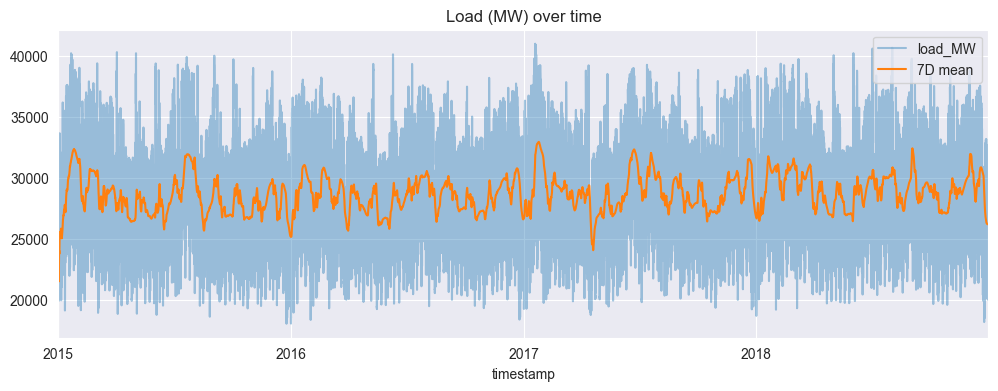

In [20]:
# Load over time with 7-day rolling mean
ax = df["load_MW"].plot(figsize=(12, 4), alpha=0.4, label="load_MW")
df["load_MW"].rolling("7D").mean().plot(ax=ax, label="7D mean")
plt.title("Load (MW) over time")
plt.legend()
plt.show()

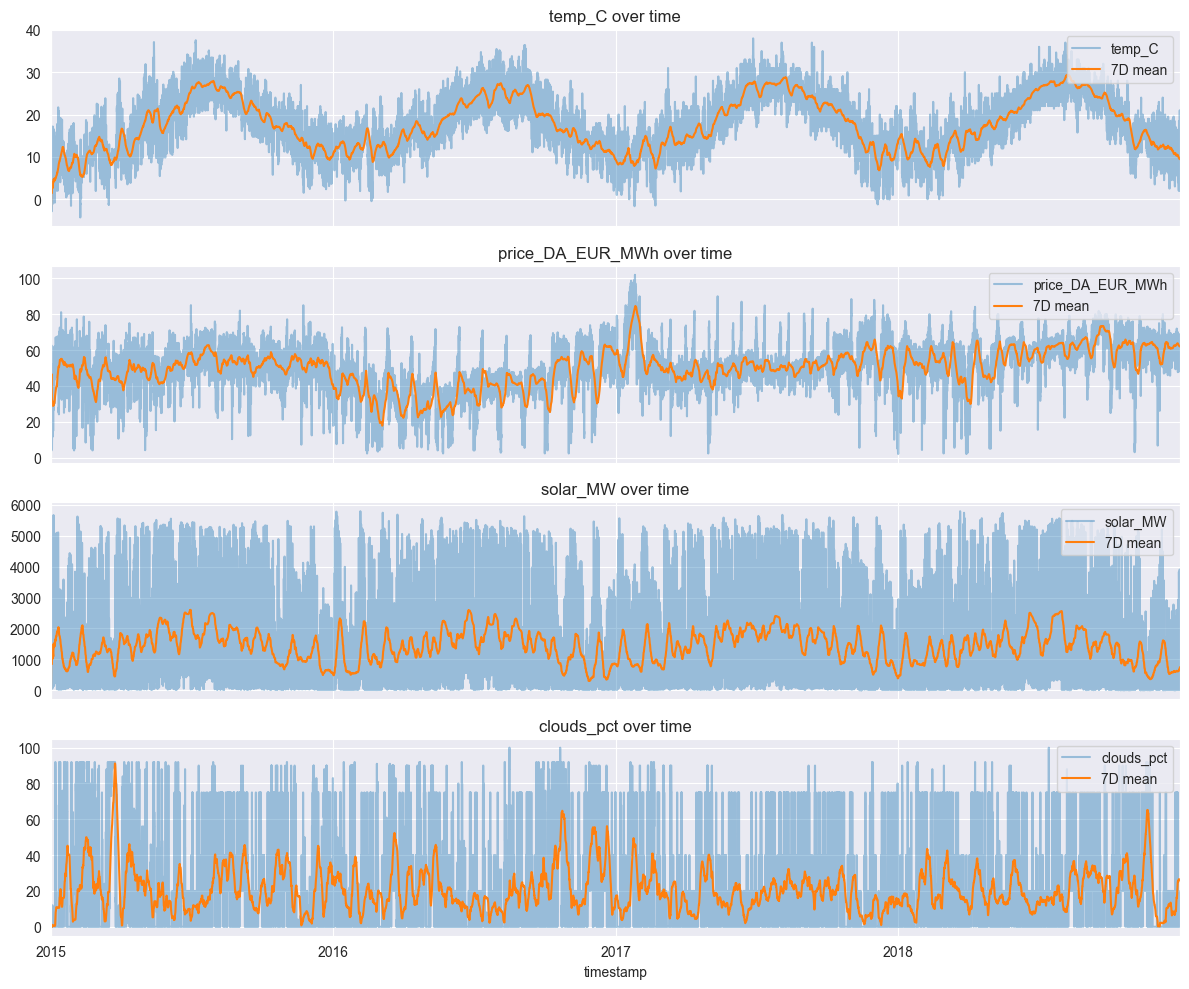

In [21]:
# Predictors over time with 7-day rolling mean
cols = ["temp_C", "price_DA_EUR_MWh", "solar_MW", "clouds_pct"]
fig, axes = plt.subplots(len(cols), 1, figsize=(12, 10), sharex=True)
for col, ax in zip(cols, axes):
    df[col].plot(ax=ax, alpha=0.4, label=col)
    df[col].rolling("7D").mean().plot(ax=ax, label="7D mean")
    ax.legend(loc="upper right")
    ax.set_title(f"{col} over time")
plt.tight_layout()
plt.show()


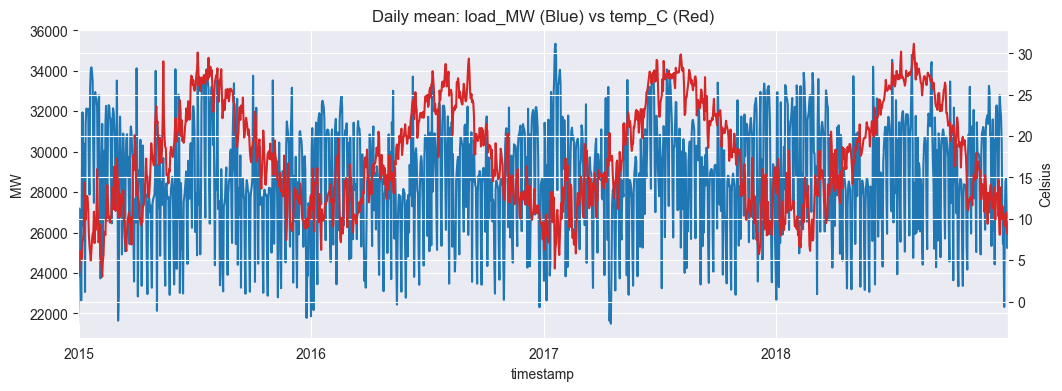

In [22]:
# Overlays (daily means): load vs temperature
daily = df.resample("D").mean()
ax = daily["load_MW"].plot(figsize=(12, 4), color="tab:blue", label="load_MW")
ax2 = ax.twinx()
daily["temp_C"].plot(ax=ax2, color="tab:red", label="temp_C")
ax.set_title("Daily mean: load_MW (Blue) vs temp_C (Red)")
ax.set_ylabel("MW")
ax2.set_ylabel("Celsius")
plt.show()


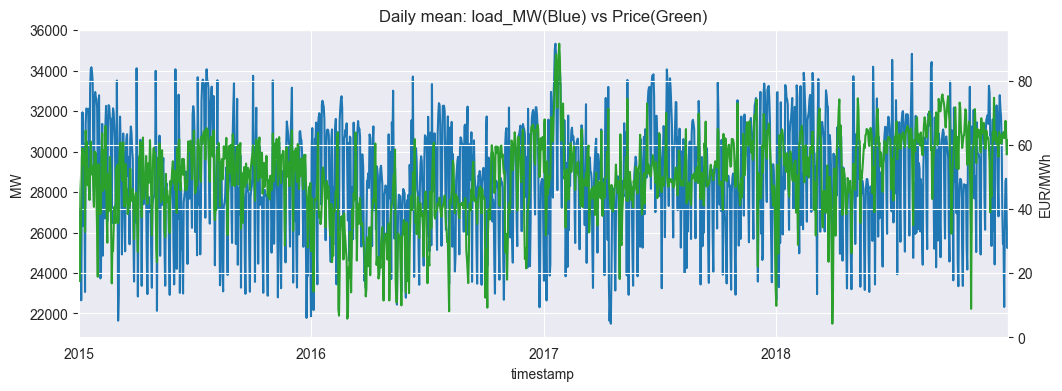

In [23]:
# Overlays (daily means): load vs price
ax = daily["load_MW"].plot(figsize=(12, 4), color="tab:blue", label="load_MW")
ax2 = ax.twinx()
daily["price_DA_EUR_MWh"].plot(ax=ax2, color="tab:green", label="price")
ax.set_title("Daily mean: load_MW(Blue) vs Price(Green)")
ax.set_ylabel("MW")
ax2.set_ylabel("EUR/MWh")
plt.show()


## Monthly and yearly analysis


In [24]:
# Monthly and yearly resamples
monthly = df.resample('M').mean()
yearly = df.resample('Y').mean()

print('Monthly shape:', monthly.shape)
print('Yearly shape:', yearly.shape)


Monthly shape: (49, 5)
Yearly shape: (5, 5)


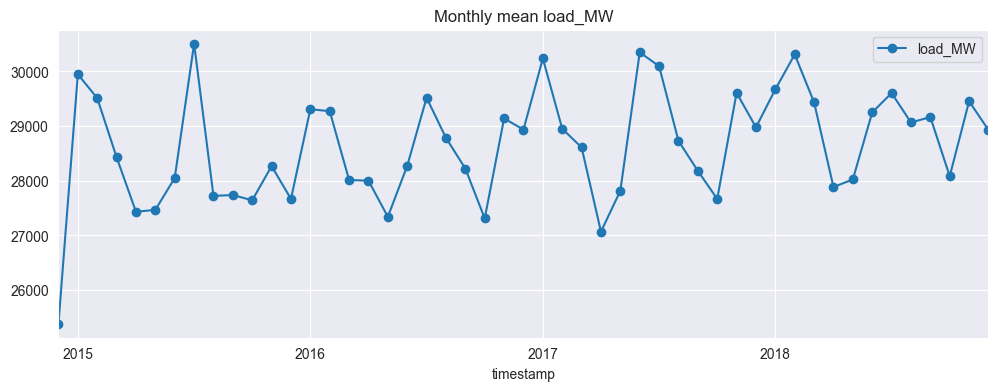

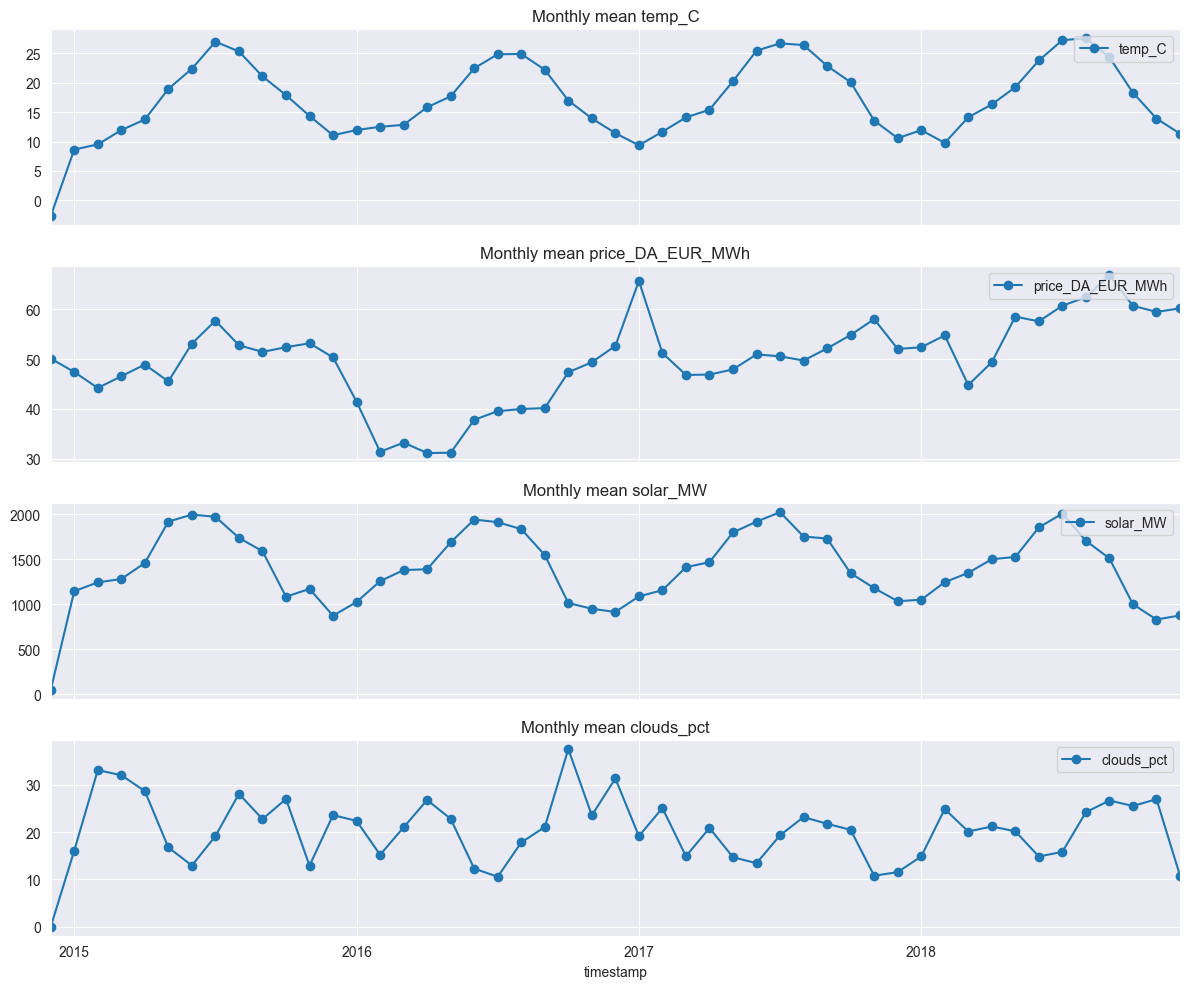

In [25]:
# Monthly plots: load and predictors
monthly['load_MW'].plot(figsize=(12, 4), marker='o', label='load_MW')
plt.title('Monthly mean load_MW')
plt.legend(); plt.show()

cols = ['temp_C', 'price_DA_EUR_MWh', 'solar_MW', 'clouds_pct']
fig, axes = plt.subplots(len(cols), 1, figsize=(12, 10), sharex=True)
for col, ax in zip(cols, axes):
    monthly[col].plot(ax=ax, marker='o', label=col)
    ax.set_title(f'Monthly mean {col}')
    ax.legend(loc='upper right')
plt.tight_layout(); plt.show()


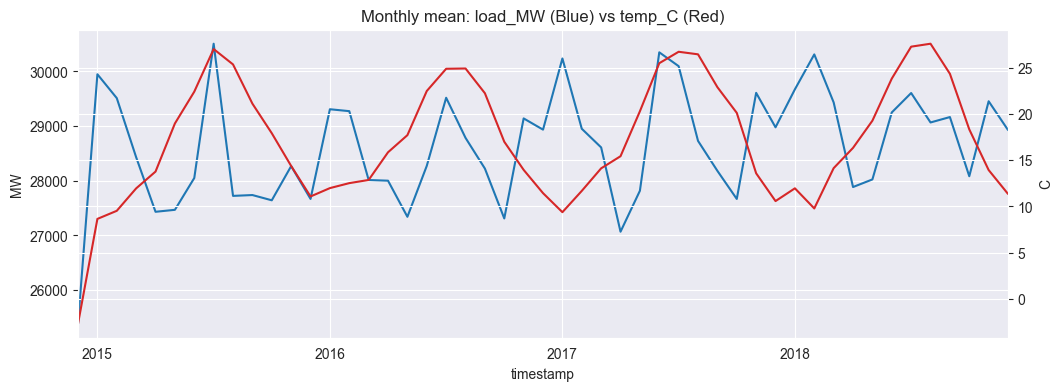

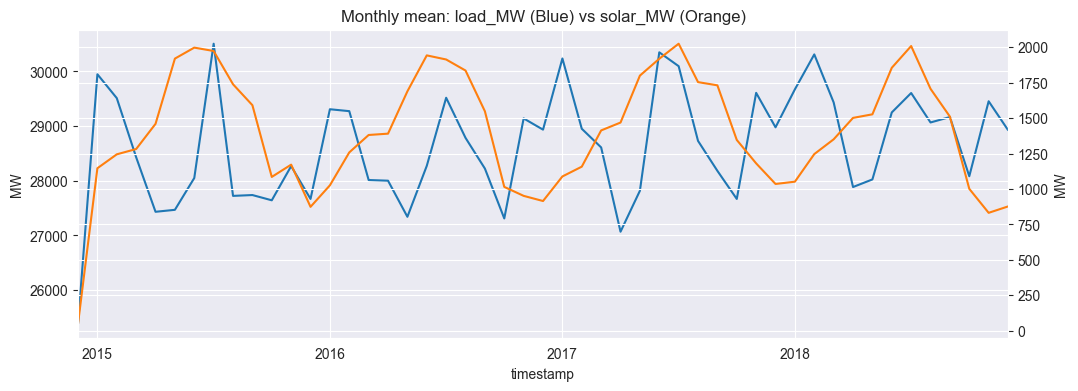

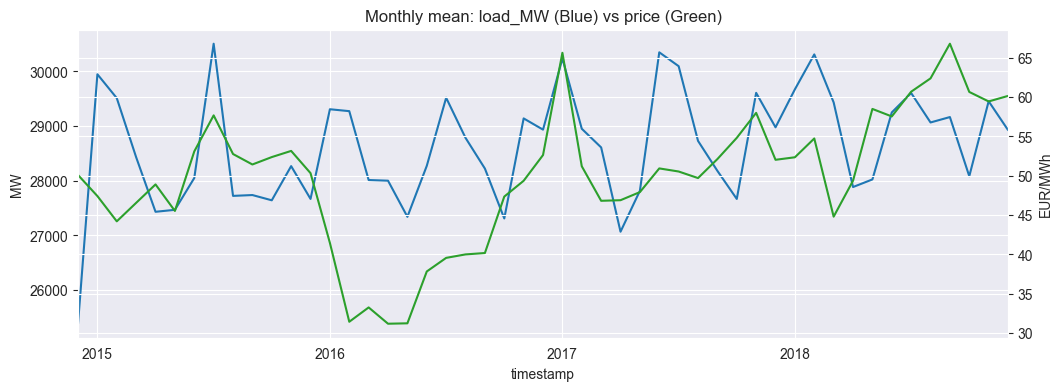

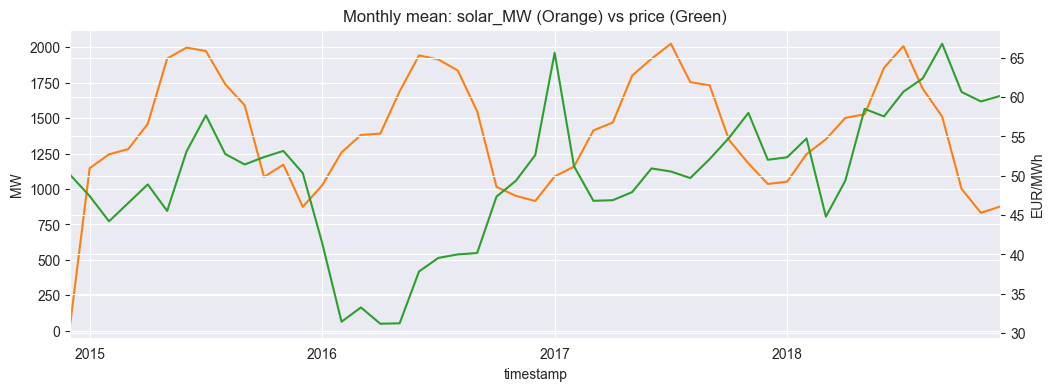

In [26]:
# Monthly overlays: load vs temp, solar, price
ax = monthly['load_MW'].plot(figsize=(12, 4), color='tab:blue', label='load_MW')
ax2 = ax.twinx(); monthly['temp_C'].plot(ax=ax2, color='tab:red', label='temp_C')
ax.set_title('Monthly mean: load_MW (Blue) vs temp_C (Red)'); ax.set_ylabel('MW'); ax2.set_ylabel('C'); plt.show()

ax = monthly['load_MW'].plot(figsize=(12, 4), color='tab:blue', label='load_MW')
ax2 = ax.twinx(); monthly['solar_MW'].plot(ax=ax2, color='tab:orange', label='solar_MW')
ax.set_title('Monthly mean: load_MW (Blue) vs solar_MW (Orange)'); ax.set_ylabel('MW'); ax2.set_ylabel('MW'); plt.show()

ax = monthly['load_MW'].plot(figsize=(12, 4), color='tab:blue', label='load_MW')
ax2 = ax.twinx(); monthly['price_DA_EUR_MWh'].plot(ax=ax2, color='tab:green', label='price')
ax.set_title('Monthly mean: load_MW (Blue) vs price (Green)'); ax.set_ylabel('MW'); ax2.set_ylabel('EUR/MWh'); plt.show()

# Monthly overlay of solar vs price
ax = monthly['solar_MW'].plot(figsize=(12, 4), color='tab:orange', label='solar_MW')
ax2 = ax.twinx(); monthly['price_DA_EUR_MWh'].plot(ax=ax2, color='tab:green', label='price')
ax.set_title('Monthly mean: solar_MW (Orange) vs price (Green)'); ax.set_ylabel('MW'); ax2.set_ylabel('EUR/MWh'); plt.show()



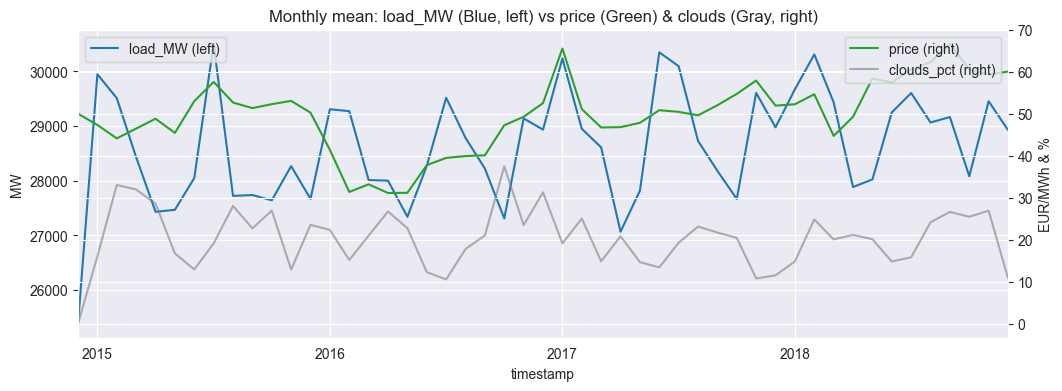

In [27]:
# Monthly overlay: load vs price vs clouds (dual axes)
ax = monthly['load_MW'].plot(figsize=(12, 4), color='tab:blue', label='load_MW (left)')
ax2 = ax.twinx()
monthly['price_DA_EUR_MWh'].plot(ax=ax2, color='tab:green', label='price (right)')
monthly['clouds_pct'].plot(ax=ax2, color='tab:gray', alpha=0.6, label='clouds_pct (right)')
ax.set_title('Monthly mean: load_MW (Blue, left) vs price (Green) & clouds (Gray, right)')
ax.set_ylabel('MW')
ax2.set_ylabel('EUR/MWh & %')
# legends on both axes
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


## Correlation and Granger causality analysis

In [28]:
# Setup for correlation and causality analysis
sns.set(style="whitegrid")

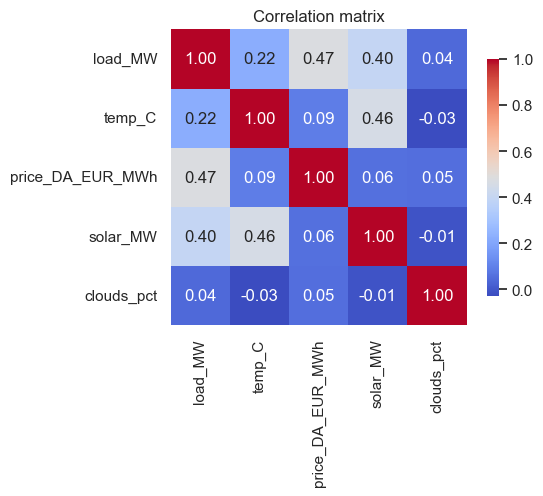

In [29]:
# Pairwise correlation matrix (hourly data)
corr = df.corr(numeric_only=True)

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

In [30]:
corr

,load_MW,temp_C,price_DA_EUR_MWh,solar_MW,clouds_pct
load_MW,1.000000,0.220790,0.474273,0.395511,0.040361
temp_C,0.220790,1.000000,0.090572,0.456586,-0.028432
price_DA_EUR_MWh,0.474273,0.090572,1.000000,0.058107,0.054474
solar_MW,0.395511,0.456586,0.058107,1.000000,-0.011355
clouds_pct,0.040361,-0.028432,0.054474,-0.011355,1.000000


In [31]:
# Correlation of each predictor with the target (load_MW)
target = "load_MW"
predictors = [c for c in df.columns if c != target]

corr_with_target = corr.loc[predictors, target].sort_values(ascending=False)
print("Correlation with load_MW (descending):")
print(corr_with_target.to_string())


Correlation with load_MW (descending):
price_DA_EUR_MWh    0.474273
solar_MW            0.395511
temp_C              0.220790
clouds_pct          0.040361


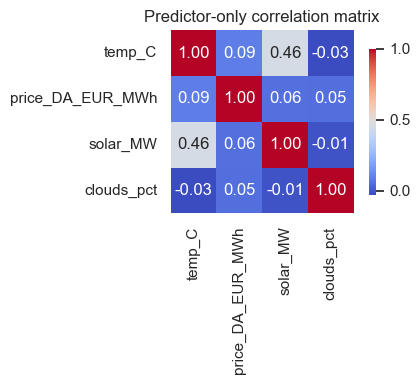

In [32]:
# Correlations among predictors only
corr_pred = df[predictors].corr(numeric_only=True)

plt.figure(figsize=(5, 4))
sns.heatmap(corr_pred, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Predictor-only correlation matrix")
plt.tight_layout()
plt.show()

In [33]:
corr_pred

,temp_C,price_DA_EUR_MWh,solar_MW,clouds_pct
temp_C,1.000000,0.090572,0.456586,-0.028432
price_DA_EUR_MWh,0.090572,1.000000,0.058107,0.054474
solar_MW,0.456586,0.058107,1.000000,-0.011355
clouds_pct,-0.028432,0.054474,-0.011355,1.000000


### Granger causality matrix


Checking stationarity for these columns:
 ['load_MW', 'temp_C', 'price_DA_EUR_MWh', 'solar_MW', 'clouds_pct']
===== load_MW =====
ADF Statistic: -21.420315756960537
p-value: 0.0
Critical Values:
	1%: -3.43053679213716
	5%: -2.8616225575095284
	10%: -2.566813942767471
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.8696600412327762
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Lags Used: 70
Conclusion: Reject H0. The time series is likely non-stationary.


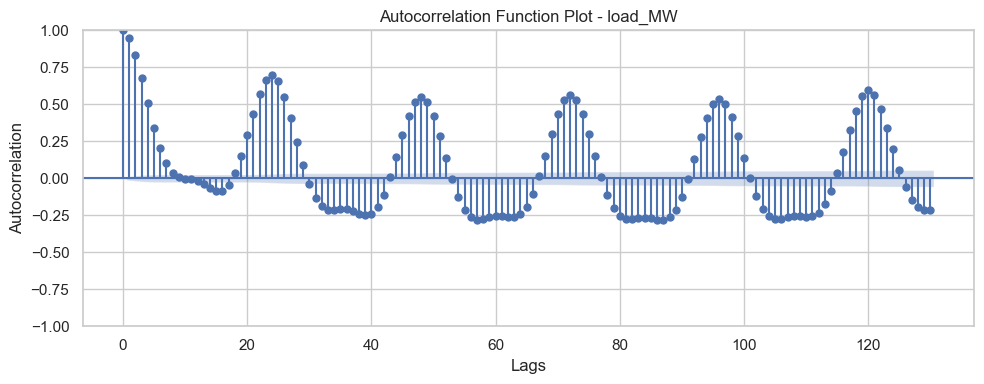

===== temp_C =====
ADF Statistic: -5.548530580178737
p-value: 1.6397889853970633e-06
Critical Values:
	1%: -3.43053679213716
	5%: -2.8616225575095284
	10%: -2.566813942767471
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 1.1249224287934536
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Lags Used: 104
Conclusion: Reject H0. The time series is likely non-stationary.


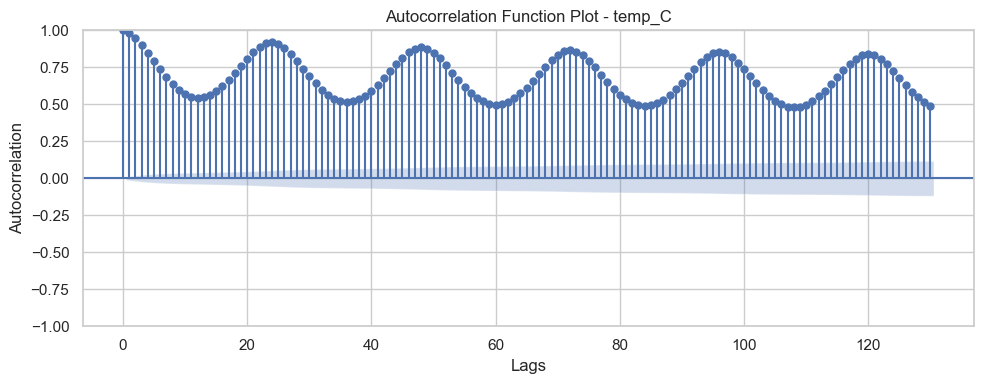

===== price_DA_EUR_MWh =====
ADF Statistic: -12.288647154284321
p-value: 7.9192577822879e-23
Critical Values:
	1%: -3.43053679213716
	5%: -2.8616225575095284
	10%: -2.566813942767471
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 6.940152364384782
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Lags Used: 106
Conclusion: Reject H0. The time series is likely non-stationary.


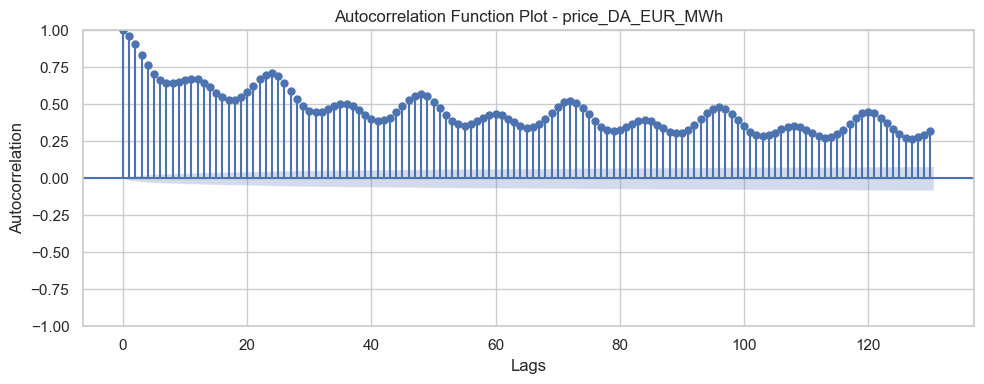

===== solar_MW =====
ADF Statistic: -13.879660013496036
p-value: 6.244855554369695e-26
Critical Values:
	1%: -3.43053679213716
	5%: -2.8616225575095284
	10%: -2.566813942767471
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.8647693577238009
P-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Lags Used: 18
Conclusion: Reject H0. The time series is likely non-stationary.


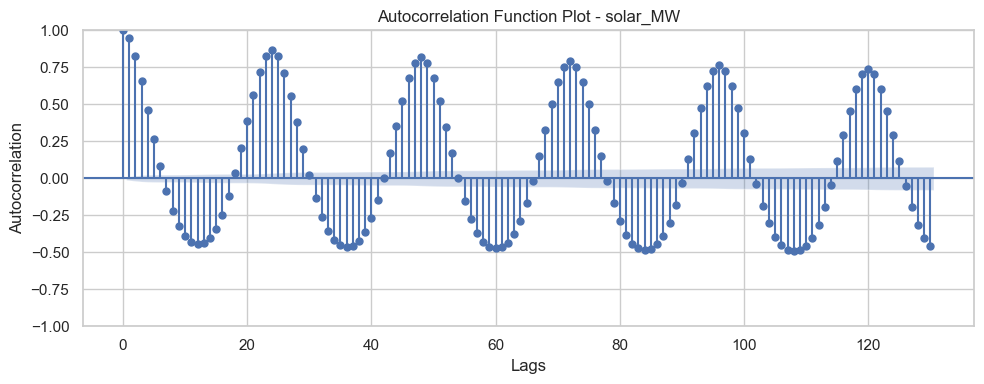

===== clouds_pct =====
ADF Statistic: -17.81952515573063
p-value: 3.1651862777261716e-30
Critical Values:
	1%: -3.43053676012885
	5%: -2.861622543363091
	10%: -2.5668139352376897
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.31207637243404157
P-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Lags Used: 102
Conclusion: Fail to reject H0. The time series is likely stationary.


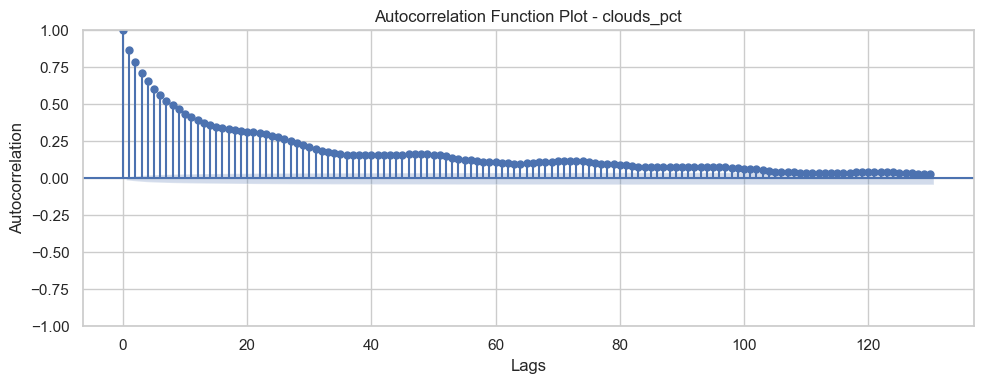

In [35]:
# Choose which columns to check (numeric only)
columns_to_check = list(df.select_dtypes(include=[np.number]).columns)

print("Checking stationarity for these columns:", columns_to_check)

for col in columns_to_check:
    series = df[col].dropna()

    # Skip if too short or constant
    if len(series) < 10 or series.nunique() < 2:
        print(f"===== {col} =====")
        print("Skipping: not enough data or no variation.")
        continue

    print(f"===== {col} =====")

    # 1) ADF test (H0: non-stationary)
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")
    if adf_result[1] <= 0.05:
        print("Conclusion: The time series is stationary (reject H0).")
    else:
        print("Conclusion: The time series is non-stationary (fail to reject H0).")

    # 2) KPSS test (H0: stationary)
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(series, regression='c', nlags='auto')
    print("KPSS Statistic:", kpss_stat)
    print("P-value:", kpss_p)
    print("Critical Values:", kpss_crit)
    print("Lags Used:", kpss_lags)
    if kpss_p > 0.05:
        print("Conclusion: Fail to reject H0. The time series is likely stationary.")
    else:
        print("Conclusion: Reject H0. The time series is likely non-stationary.")

    # 3) ACF plot
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series, lags=130, alpha=0.05, ax=ax)
    ax.set_title(f'Autocorrelation Function Plot - {col}')
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')
    plt.tight_layout()
    plt.show()

## Seasonal differencing (lag 24)


In [36]:
# Apply seasonal differencing with lag 24 to each variable
# Formula: X_sdiff = X_t - X_{t-24}

load_MW_sdiff = df['load_MW'] - df['load_MW'].shift(24)
temp_C_sdiff = df['temp_C'] - df['temp_C'].shift(24)
price_DA_EUR_MWh_sdiff = df['price_DA_EUR_MWh'] - df['price_DA_EUR_MWh'].shift(24)
solar_MW_sdiff = df['solar_MW'] - df['solar_MW'].shift(24)
clouds_pct_sdiff = df['clouds_pct'] - df['clouds_pct'].shift(24)

print("Seasonal differencing applied with lag 24.")
print(f"Each series will have 24 NaN values at the beginning.")


Seasonal differencing applied with lag 24.
Each series will have 24 NaN values at the beginning.


In [37]:
# Create a new DataFrame with the seasonally differenced series
df_stationary = pd.DataFrame({
    'load_MW_sdiff': load_MW_sdiff,
    'temp_C_sdiff': temp_C_sdiff,
    'price_DA_EUR_MWh_sdiff': price_DA_EUR_MWh_sdiff,
    'solar_MW_sdiff': solar_MW_sdiff,
    'clouds_pct_sdiff': clouds_pct_sdiff
}, index=df.index)

In [38]:
# Check missing values before dropping
print("Missing values before dropping NaNs:")
print(df_stationary.isna().sum())
print(f"DataFrame shape before: {df_stationary.shape}")


Missing values before dropping NaNs:
load_MW_sdiff             24
temp_C_sdiff              24
price_DA_EUR_MWh_sdiff    24
solar_MW_sdiff            24
clouds_pct_sdiff          24
dtype: int64
DataFrame shape before: (35064, 5)


In [39]:
# Remove the first 24 rows that contain NaN values
df_stationary = df_stationary.dropna()

# Verify no missing values remain
print("Missing values after dropping NaNs:")
print(df_stationary.isna().sum())


Missing values after dropping NaNs:
load_MW_sdiff             0
temp_C_sdiff              0
price_DA_EUR_MWh_sdiff    0
solar_MW_sdiff            0
clouds_pct_sdiff          0
dtype: int64


In [108]:
# Keep the last 48 original observations for inverting forecasts later
# When we forecast differenced values, we need to add them back to the original values
last_48_original = df[['load_MW', 'temp_C', 'price_DA_EUR_MWh', 'solar_MW', 'clouds_pct']].iloc[-48:]

In [109]:
print("Saved last 48 original observations for forecast inversion.")
print(f"Shape: {last_48_original.shape}")

Saved last 48 original observations for forecast inversion.
Shape: (48, 5)


Re-checking stationarity for seasonally differenced series:
 ['load_MW_sdiff', 'temp_C_sdiff', 'price_DA_EUR_MWh_sdiff', 'solar_MW_sdiff', 'clouds_pct_sdiff']
===== load_MW_sdiff =====
ADF Statistic: -28.9519
p-value: 0.000000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.0049
P-value: 0.10
Critical Values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
Lags Used: 102
Conclusion: Fail to reject H0. The time series is likely stationary.


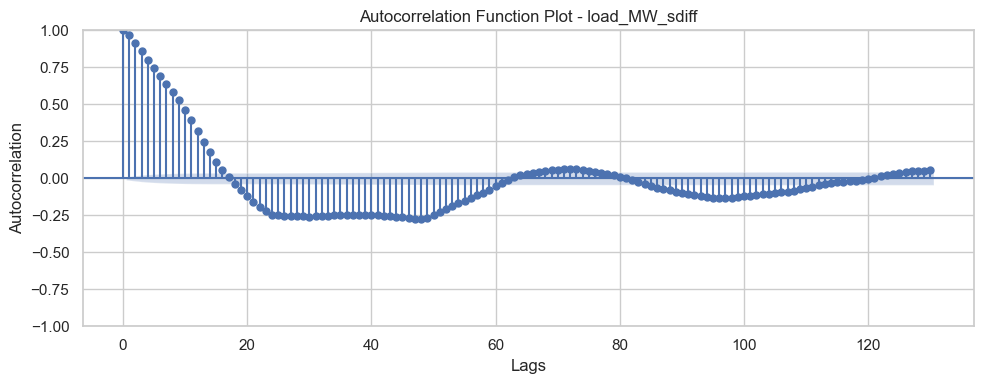

===== temp_C_sdiff =====
ADF Statistic: -28.7559
p-value: 0.000000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.0534
P-value: 0.10
Critical Values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
Lags Used: 94
Conclusion: Fail to reject H0. The time series is likely stationary.


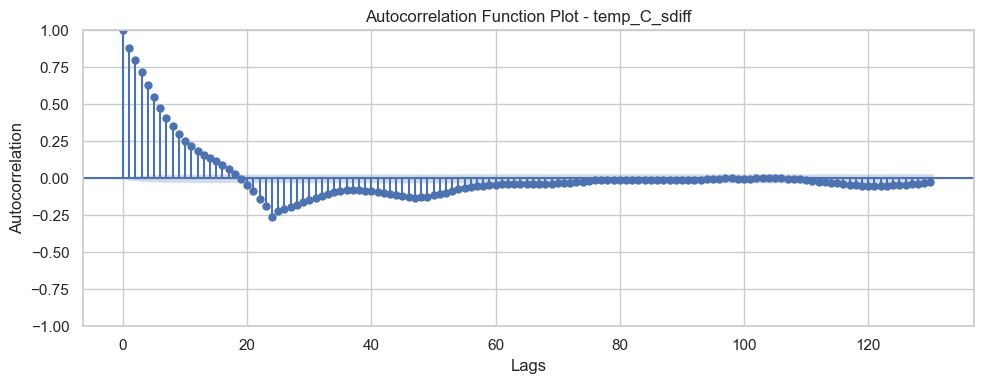

===== price_DA_EUR_MWh_sdiff =====
ADF Statistic: -28.6836
p-value: 0.000000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.0028
P-value: 0.10
Critical Values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
Lags Used: 100
Conclusion: Fail to reject H0. The time series is likely stationary.


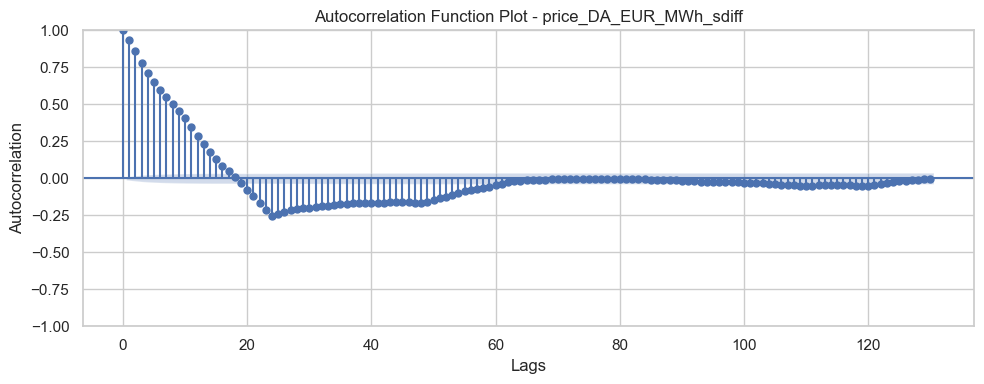

===== solar_MW_sdiff =====
ADF Statistic: -28.6160
p-value: 0.000000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.0023
P-value: 0.10
Critical Values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
Lags Used: 88
Conclusion: Fail to reject H0. The time series is likely stationary.


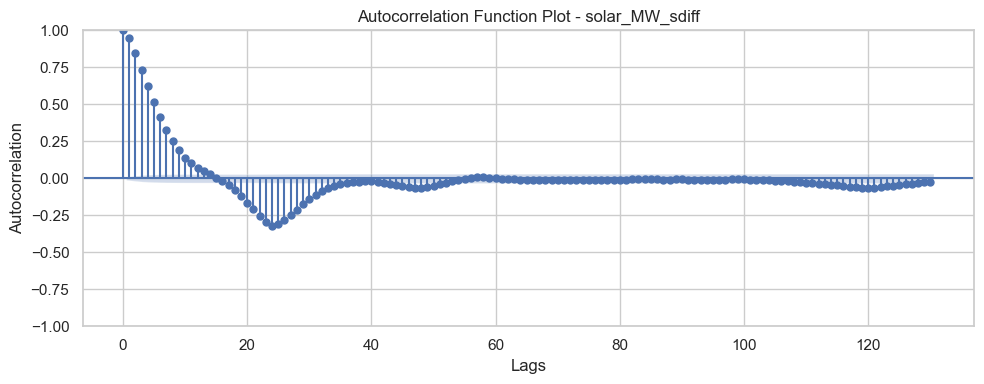

===== clouds_pct_sdiff =====
ADF Statistic: -30.4603
p-value: 0.000000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: The time series is stationary (reject H0).
KPSS Statistic: 0.0034
P-value: 0.10
Critical Values: {'10%': '0.347', '5%': '0.463', '2.5%': '0.574', '1%': '0.739'}
Lags Used: 94
Conclusion: Fail to reject H0. The time series is likely stationary.


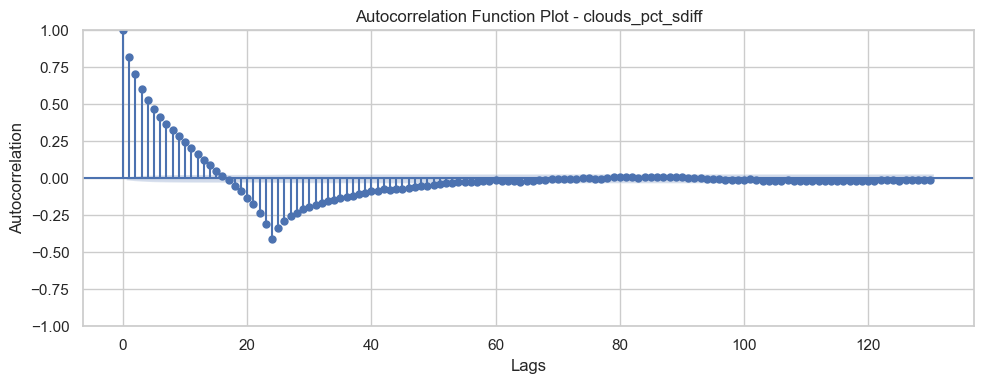

In [42]:
# Re-check stationarity for all differenced columns
columns_to_check_diff = list(df_stationary.columns)

print("Re-checking stationarity for seasonally differenced series:", columns_to_check_diff)

for col in columns_to_check_diff:
    series = df_stationary[col].dropna()

    # Skip if too short or constant
    if len(series) < 10 or series.nunique() < 2:
        print(f"===== {col} =====")
        print("Skipping: not enough data or no variation.")
        continue

    print(f"===== {col} =====")

    # 1) ADF test (H0: non-stationary)
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.4f}")
    if adf_result[1] <= 0.05:
        print("Conclusion: The time series is stationary (reject H0).")
    else:
        print("Conclusion: The time series is non-stationary (fail to reject H0).")

    # 2) KPSS test (H0: stationary)
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(series, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_stat:.4f}")
    print(f"P-value: {kpss_p:.2f}")
    print("Critical Values:", {k: f"{v:.3f}" for k, v in kpss_crit.items()})
    print(f"Lags Used: {kpss_lags}")
    if kpss_p > 0.05:
        print("Conclusion: Fail to reject H0. The time series is likely stationary.")
    else:
        print("Conclusion: Reject H0. The time series is likely non-stationary.")

    # 3) ACF plot
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series, lags=130, alpha=0.05, ax=ax)
    ax.set_title(f'Autocorrelation Function Plot - {col}')
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')
    plt.tight_layout()
    plt.show()

In [43]:
# Helper function: Granger causality matrix

def granger_matrix(data, variables, maxlag=24):
    # Start with a table filled with NaN
    result = pd.DataFrame(np.nan, index=variables, columns=variables)

    for y in variables:  # response (Y)
        for x in variables:  # predictor (X)
            if x == y:
                continue  # skip same variable

            # Use only the two series we need and drop missing values
            pair = data[[y, x]].dropna()

            # If we do not have enough data, skip this pair
            if len(pair) <= maxlag + 5:
                continue

            # Run Granger causality tests for lags 1..maxlag
            tests = grangercausalitytests(pair, maxlag=maxlag, verbose=False)

            # Collect p-values from the F-tests and take the minimum
            pvals = [tests[lag][0]['ssr_ftest'][1] for lag in range(1, maxlag + 1)]
            result.loc[y, x] = float(np.min(pvals))

    result.index.name = 'Y (response)'
    result.columns.name = 'X (predictor)'
    return result


In [44]:
# Define variables for stationary data (with _sdiff suffix)
stationary_vars = ['load_MW_sdiff', 'temp_C_sdiff', 'price_DA_EUR_MWh_sdiff', 'solar_MW_sdiff', 'clouds_pct_sdiff']

print("Running Granger causality test on STATIONARY data....")
print(f"Variables: {stationary_vars}")
print(f"Max lag: 24 hours\n")

# Run the Granger causality matrix on stationary data
G_stationary = granger_matrix(df_stationary, stationary_vars, maxlag=24)

print("Min p-values across lags (columns X -> rows Y):")
print("(p < 0.05 means X helps predict Y)")
print("\n" + "="*70)
print(G_stationary.round(4))
print("="*70)


Running Granger causality test on STATIONARY data....
Variables: ['load_MW_sdiff', 'temp_C_sdiff', 'price_DA_EUR_MWh_sdiff', 'solar_MW_sdiff', 'clouds_pct_sdiff']
Max lag: 24 hours
Min p-values across lags (columns X -> rows Y):
(p < 0.05 means X helps predict Y)

X (predictor)           load_MW_sdiff  temp_C_sdiff  price_DA_EUR_MWh_sdiff  \
Y (response)                                                                  
load_MW_sdiff                     NaN        0.0133                  0.0000   
temp_C_sdiff                   0.1899           NaN                  0.0000   
price_DA_EUR_MWh_sdiff         0.0000        0.0754                     NaN   
solar_MW_sdiff                 0.0000        0.0000                  0.0000   
clouds_pct_sdiff               0.0696        0.0000                  0.0085   

X (predictor)           solar_MW_sdiff  clouds_pct_sdiff  
Y (response)                                              
load_MW_sdiff                      0.0            0.0582  
temp

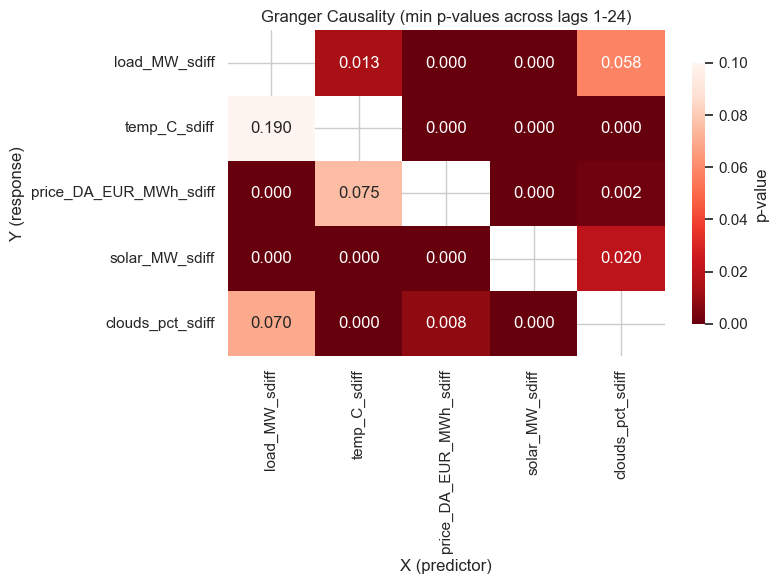

In [45]:
# Visualize Granger causality p-values as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(G_stationary, annot=True, fmt=".3f", cmap="Reds_r", vmin=0, vmax=0.1, 
            cbar_kws={"shrink": 0.8, "label": "p-value"})
plt.title("Granger Causality (min p-values across lags 1-24)")
plt.xlabel("X (predictor)")
plt.ylabel("Y (response)")
plt.tight_layout()
plt.show()


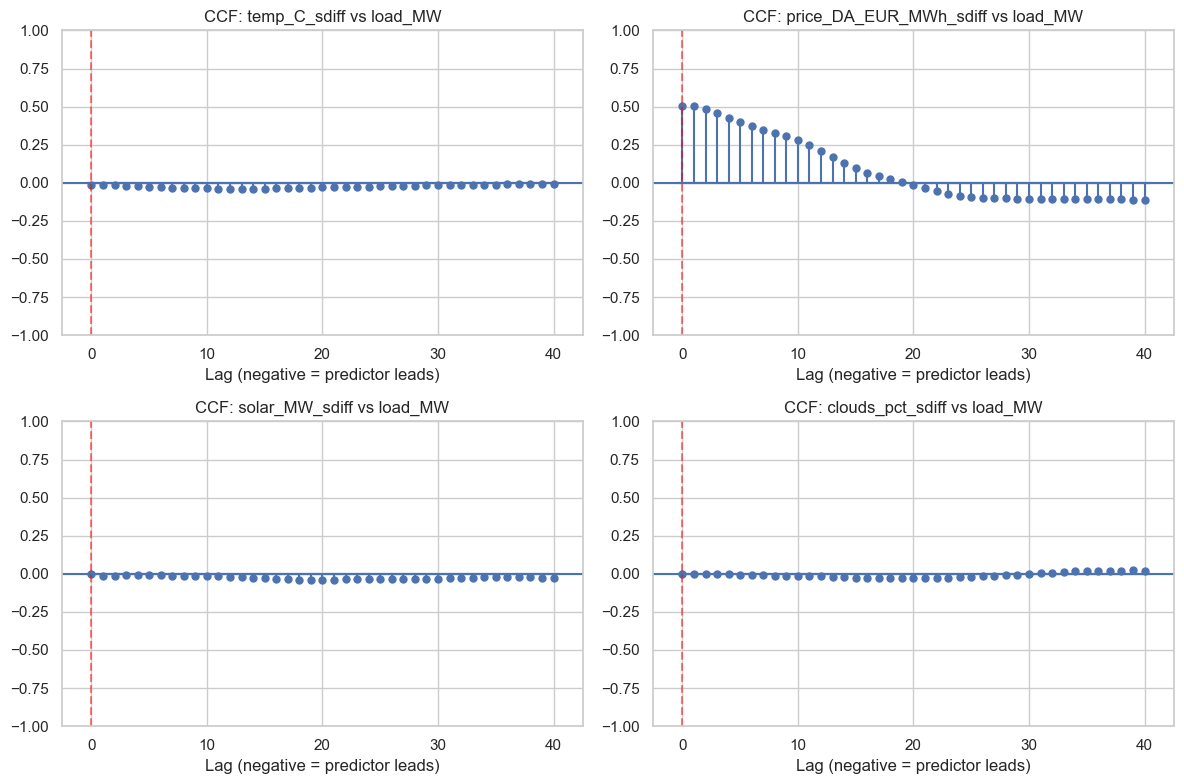

In [46]:
# CCF plots: load_MW vs each predictor
predictors = ['temp_C_sdiff', 'price_DA_EUR_MWh_sdiff', 'solar_MW_sdiff', 'clouds_pct_sdiff']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, pred in enumerate(predictors):
    plot_ccf(df_stationary['load_MW_sdiff'], df_stationary[pred], 
             lags=40, alpha=0.05, ax=axes[i])
    axes[i].set_title(f'CCF: {pred} vs load_MW')
    axes[i].set_xlabel('Lag (negative = predictor leads)')
    axes[i].axvline(0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [47]:
# CROSS-CORRELATION 

def simple_ccf(predictor_series, target_series, max_lag=24):
    # Get data and align timestamps
    x = predictor_series.dropna()
    y = target_series.dropna()
    common = x.index.intersection(y.index)
    x = x.loc[common]
    y = y.loc[common]
    
    # Center the data (subtract mean)
    x = x - x.mean()
    y = y - y.mean()
    
    # Calculate correlation for each lag
    results = []
    for lag in range(0, max_lag + 1):
        # Lag k: X from k hours ago vs Y now
        # This means: can X predict Y with k hours lead time?
        if lag == 0:
            x_past = x
            y_now = y
        else:
            x_past = x.iloc[:-lag]  # Earlier X values
            y_now = y.iloc[lag:]    # Later Y values
        
        # Calculate correlation
        if len(x_past) > 1:
            corr = np.corrcoef(x_past, y_now)[0, 1]
            results.append({
                'lag_hours': lag,
                'correlation': round(corr, 4)
            })
    
    return pd.DataFrame(results)

In [48]:
# Run CCF for each predictor
print("="*70)
print("CROSS-CORRELATION: How past predictors relate to current load")
print("="*70)

predictors = ['temp_C_sdiff', 'price_DA_EUR_MWh_sdiff', 'solar_MW_sdiff', 'clouds_pct_sdiff']

for pred in predictors:
    print(f"\n{'='*70}")
    print(f"Predictor: {pred}")
    print(f"Target: load_MW_sdiff")
    print(f"{'='*70}")
    
    # Calculate CCF
    ccf_table = simple_ccf(df_stationary[pred], df_stationary['load_MW_sdiff'], max_lag=24)
    
    # Show first lags
    print("First 10 lags:")
    print(ccf_table.head(10).to_string(index=False))
    
    # Show strongest correlations
    print("Top 5 strongest correlations:")
    ccf_table['abs_corr'] = ccf_table['correlation'].abs()
    top5 = ccf_table.sort_values('abs_corr', ascending=False).head(5)
    print(top5[['lag_hours', 'correlation']].to_string(index=False))
    
    # Best lag
    best_idx = top5.iloc[0]
    print(f" Best lag: {int(best_idx['lag_hours'])} hours ago")
    print(f" Correlation: {best_idx['correlation']:.4f}")
    if abs(best_idx['correlation']) > 0.3:
        print(f" Strong relationship!")
    elif abs(best_idx['correlation']) > 0.1:
        print(f" Moderate relationship")
    else:
        print(f" Weak relationship")

print("\n" + "="*70)
print(" CCF complete!")
print("="*70)


CROSS-CORRELATION: How past predictors relate to current load

Predictor: temp_C_sdiff
Target: load_MW_sdiff

First 10 lags:
 lag_hours  correlation
         0      -0.0127
         1      -0.0145
         2      -0.0175
         3      -0.0213
         4      -0.0243
         5      -0.0272
         6      -0.0300
         7      -0.0322
         8      -0.0336
         9      -0.0349

Top 5 strongest correlations:
 lag_hours  correlation
        13      -0.0396
        12      -0.0395
        14      -0.0392
        11      -0.0385
        15      -0.0376

→ Best lag: 13 hours ago
→ Correlation: -0.0396
→ Weak relationship

Predictor: price_DA_EUR_MWh_sdiff
Target: load_MW_sdiff

First 10 lags:
 lag_hours  correlation
         0       0.5065
         1       0.5049
         2       0.4841
         3       0.4551
         4       0.4252
         5       0.3967
         6       0.3712
         7       0.3483
         8       0.3270
         9       0.3051

Top 5 strongest correlations:

In [49]:
# Check the total number of observations
print("Total observations in df_stationary:", len(df_stationary))
print("Date range:", df_stationary.index.min(), "to", df_stationary.index.max())

# Set test size to last 48 hours
test_size = 48
print(f"We will use the last {test_size} hours as test set")

Total observations in df_stationary: 35040
Date range: 2015-01-01 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
We will use the last 48 hours as test set


In [50]:
# Split the data: last 48 observations = test, everything before = train
train = df_stationary.iloc[:-test_size]  # All rows except the last 48
test = df_stationary.iloc[-test_size:]   # Only the last 48 rows

print("Train set:")
print(f"Shape: {train.shape}")
print(f"Date range: {train.index.min()} to {train.index.max()}")

Train set:
Shape: (34992, 5)
Date range: 2015-01-01 23:00:00+00:00 to 2018-12-29 22:00:00+00:00


In [51]:
print("Test set:")
print(f"Shape: {test.shape}")
print(f"Date range: {test.index.min()} to {test.index.max()}")

Test set:
Shape: (48, 5)
Date range: 2018-12-29 23:00:00+00:00 to 2018-12-31 22:00:00+00:00


In [52]:
# Create scaler and fit ONLY on training data
scaler = StandardScaler()
scaler.fit(train)

print("Scaler fitted on TRAIN set only")
print("Learned mean from training data:")
for col, mean_val in zip(train.columns, scaler.mean_):
    print(f"  {col}: {mean_val:.4f}")

Scaler fitted on TRAIN set only

Learned mean from training data:
  load_MW_sdiff: 1.8793
  temp_C_sdiff: 0.0043
  price_DA_EUR_MWh_sdiff: 0.0071
  solar_MW_sdiff: -0.2663
  clouds_pct_sdiff: 0.0124


In [53]:
print("Learned std from training data:")
for col, std_val in zip(train.columns, scaler.scale_):
    print(f"  {col}: {std_val:.4f}")



Learned std from training data:
  load_MW_sdiff: 3531.3267
  temp_C_sdiff: 2.7822
  price_DA_EUR_MWh_sdiff: 11.1017
  solar_MW_sdiff: 856.1080
  clouds_pct_sdiff: 30.5611


In [54]:
# Transform both train and test using the scaler fitted on train
train_scaled = pd.DataFrame(
    scaler.transform(train),
    index=train.index,
    columns=train.columns
)

test_scaled = pd.DataFrame(
    scaler.transform(test),
    index=test.index,
    columns=test.columns
)

print("Scaled train set:")
print(f"  Shape: {train_scaled.shape}")
print(f"  Mean: {train_scaled.mean().mean():.10f} (should be ~0)")
print(f"  Std: {train_scaled.std().mean():.4f} (should be ~1)")

print("Scaled test set:")
print(f"  Shape: {test_scaled.shape}")
print(f"  Mean: {test_scaled.mean().mean():.4f} (may not be exactly 0)")
print(f"  Std: {test_scaled.std().mean():.4f} (may not be exactly 1)")

Scaled train set:
  Shape: (34992, 5)
  Mean: 0.0000000000 (should be ~0)
  Std: 1.0000 (should be ~1)
Scaled test set:
  Shape: (48, 5)
  Mean: 0.0053 (may not be exactly 0)
  Std: 0.4406 (may not be exactly 1)


In [55]:
# Summary 
print("Data ready. Shapes:")
print({
    'df': df.shape,
    'df_stationary': df_stationary.shape,
    'train': train.shape,
    'test': test.shape
})

Data ready. Shapes:
{'df': (35064, 5), 'df_stationary': (35040, 5), 'train': (34992, 5), 'test': (48, 5)}


## VAR Model - Lag Order Selection


In [56]:
# Only include load_MW and price in the model
train_reduced = train[['load_MW_sdiff', 'price_DA_EUR_MWh_sdiff']]

max_lags = 300
aic_values = []
bic_values = []

for lag in range(1, max_lags + 1):
    model = VAR(train_reduced)
    result = model.fit(lag)
    aic_values.append(result.aic)
    bic_values.append(result.bic)

aic_df = pd.DataFrame({
    'lag': range(1, max_lags + 1),
    'AIC': aic_values,
    'BIC': bic_values
})

In [57]:
best_aic_lag = aic_df.loc[aic_df['AIC'].idxmin(), 'lag']
best_bic_lag = aic_df.loc[aic_df['BIC'].idxmin(), 'lag']

print(f"Best lag by AIC: {int(best_aic_lag)}")
print(f"Best lag by BIC: {int(best_bic_lag)}")

Best lag by AIC: 290
Best lag by BIC: 146


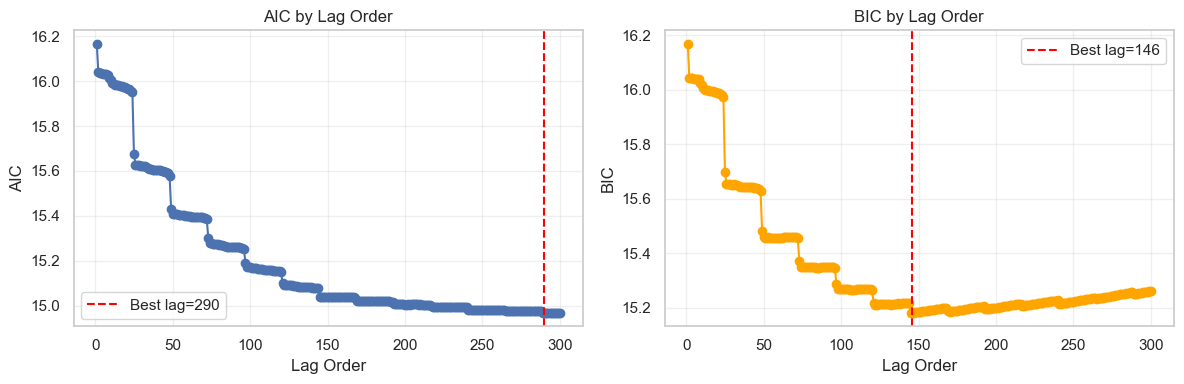

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(aic_df['lag'], aic_df['AIC'], marker='o')
axes[0].axvline(best_aic_lag, color='red', linestyle='--', label=f'Best lag={int(best_aic_lag)}')
axes[0].set_xlabel('Lag Order')
axes[0].set_ylabel('AIC')
axes[0].set_title('AIC by Lag Order')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(aic_df['lag'], aic_df['BIC'], marker='o', color='orange')
axes[1].axvline(best_bic_lag, color='red', linestyle='--', label=f'Best lag={int(best_bic_lag)}')
axes[1].set_xlabel('Lag Order')
axes[1].set_ylabel('BIC')
axes[1].set_title('BIC by Lag Order')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## VAR Model Fitting


In [59]:
model = VAR(train_reduced, freq='h')

# Use train_reduced (without temp_C_sdiff,clouds_pct_sdiff and solar)
var_model = model.fit(146)

print(f"VAR model fitted with lag order: {best_bic_lag}")
print(f"Variables used: {list(train_reduced.columns)}")
print(f"\nModel AIC: {var_model.aic:.2f}")
print(f"Model BIC: {var_model.bic:.2f}")


VAR model fitted with lag order: 146
Variables used: ['load_MW_sdiff', 'price_DA_EUR_MWh_sdiff']

Model AIC: 15.04
Model BIC: 15.18


## VAR Forecasting (48 Hours)


In [60]:
forecast_steps = 48
lag= 146
forecast_diff = var_model.forecast(train_reduced.values[-lag:], steps=forecast_steps)

## Forecast inversion to original scale


In [61]:
# Convert raw forecast array to DataFrame on the differenced scale
forecast_diff_df = pd.DataFrame(
    forecast_diff,
    index=test.index,  # 48 timestamps in the test window
    columns=train_reduced.columns
)

In [62]:
# Columns we want in original scale
orig_cols = ['load_MW', 'price_DA_EUR_MWh']

In [63]:
# Prepare output frame
forecast_original = pd.DataFrame(index=test.index, columns=orig_cols, dtype=float)

In [64]:
# Get the 24 original observations immediately before the test window
# These are used to invert the first 24 differenced forecasts
base_orig = df[orig_cols].iloc[-72:-48].reset_index(drop=True)

seasonal_lag = 24

In [65]:
# inversion loop
for t in range(len(test.index)):
    ts = test.index[t]
    if t < seasonal_lag:
        # Add forecasted seasonal difference to the original value 24 hours earlier (from base_orig)
        forecast_original.loc[ts, 'load_MW'] = base_orig.loc[t, 'load_MW'] + forecast_diff_df.loc[ts, 'load_MW_sdiff']
        forecast_original.loc[ts, 'price_DA_EUR_MWh'] = base_orig.loc[t, 'price_DA_EUR_MWh'] + forecast_diff_df.loc[ts, 'price_DA_EUR_MWh_sdiff']
    else:
        # From step 24 onward, add the differenced forecast to our own forecast 24 hours earlier
        prev_ts = test.index[t - seasonal_lag]
        forecast_original.loc[ts, 'load_MW'] = forecast_original.loc[prev_ts, 'load_MW'] + forecast_diff_df.loc[ts, 'load_MW_sdiff']
        forecast_original.loc[ts, 'price_DA_EUR_MWh'] = forecast_original.loc[prev_ts, 'price_DA_EUR_MWh'] + forecast_diff_df.loc[ts, 'price_DA_EUR_MWh_sdiff']

# Convenience series for later cells
forecast_VAR = forecast_original['load_MW']
print('Created forecast_original (original scale) and forecast_VAR (load only).')


Created forecast_original (original scale) and forecast_VAR (load only).


In [66]:
forecast_VAR = forecast_original['load_MW']

print("VAR forecast for load_MW stored as 'forecast_VAR'")
print(f" Forecast statistics:")
print(f"  Mean: {forecast_VAR.mean():.2f} MW")
print(f"  Min: {forecast_VAR.min():.2f} MW")
print(f"  Max: {forecast_VAR.max():.2f} MW")


VAR forecast for load_MW stored as 'forecast_VAR'
 Forecast statistics:
  Mean: 25763.44 MW
  Min: 19809.99 MW
  Max: 29482.70 MW


In [67]:
actual_load = df.loc[test.index, 'load_MW']

comparison = pd.DataFrame({
    'Actual': actual_load.values,
    'Predicted': forecast_VAR.values,
    'Error': forecast_VAR.values - actual_load.values,
    'Abs_Error': np.abs(forecast_VAR.values - actual_load.values),
    'Pct_Error': ((forecast_VAR.values - actual_load.values) / actual_load.values * 100)
}, index=test.index)

# Preview a few rows only
print("Actual vs Predicted (first 5 rows):")
print(comparison.head().to_string())


Actual vs Predicted (first 5 rows):
                            Actual     Predicted       Error   Abs_Error  Pct_Error
timestamp                                                                          
2018-12-29 23:00:00+00:00  24922.0  25223.596811  301.596811  301.596811   1.210163
2018-12-30 00:00:00+00:00  22772.0  23221.909457  449.909457  449.909457   1.975713
2018-12-30 01:00:00+00:00  21301.0  21686.230408  385.230408  385.230408   1.808509
2018-12-30 02:00:00+00:00  20386.0  20859.336999  473.336999  473.336999   2.321873
2018-12-30 03:00:00+00:00  20103.0  20580.802642  477.802642  477.802642   2.376773


In [68]:
print(" Error Statistics:")
print(f"  Mean Error: {comparison['Error'].mean():.2f} MW")
print(f"  Mean Absolute Error: {comparison['Abs_Error'].mean():.2f} MW")
print(f"  Mean Absolute Percentage Error: {comparison['Pct_Error'].abs().mean():.2f}%")
print(f"  Max Overprediction: {comparison['Error'].max():.2f} MW")
print(f"  Max Underprediction: {comparison['Error'].min():.2f} MW")


 Error Statistics:
  Mean Error: 182.86 MW
  Mean Absolute Error: 696.24 MW
  Mean Absolute Percentage Error: 2.74%
  Max Overprediction: 1987.21 MW
  Max Underprediction: -1264.20 MW


## VAR Forecast Evaluation


In [69]:
actual_load = df.loc[test.index, 'load_MW']

mae_var = mean_absolute_error(actual_load, forecast_VAR)
mse_var = mean_squared_error(actual_load, forecast_VAR)
rmse_var = np.sqrt(mse_var)

print("VAR Model Performance (on original scale):")
print(f"  MAE:  {mae_var:.2f} MW")
print(f"  RMSE: {rmse_var:.2f} MW")
print(f"  MSE:  {mse_var:.2f}")


VAR Model Performance (on original scale):
  MAE:  696.24 MW
  RMSE: 856.74 MW
  MSE:  733995.20


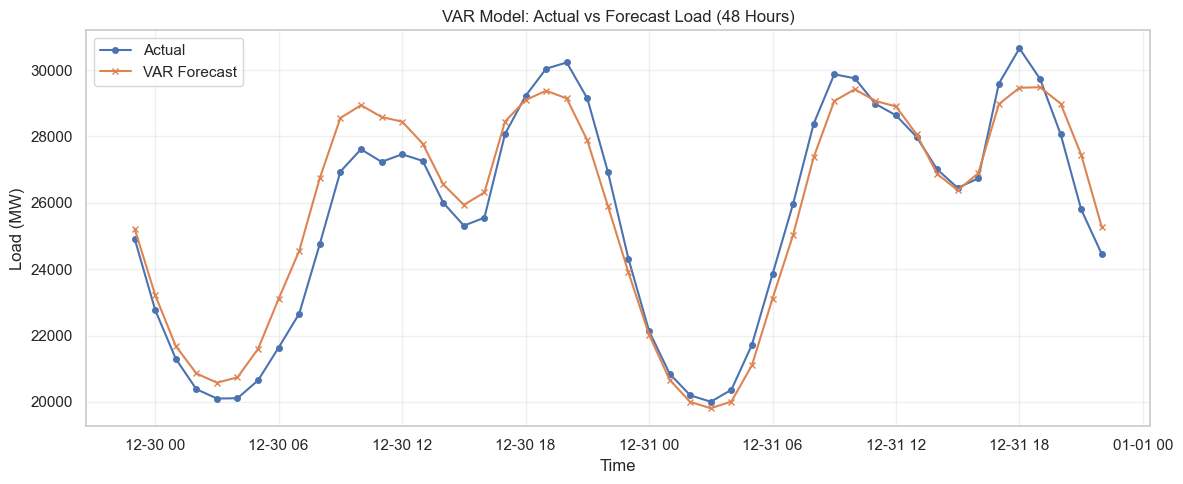

In [70]:
plt.figure(figsize=(12, 5))
plt.plot(actual_load.index, actual_load.values, label='Actual', marker='o', markersize=4)
plt.plot(forecast_VAR.index, forecast_VAR.values, label='VAR Forecast', marker='x', markersize=4)
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('VAR Model: Actual vs Forecast Load (48 Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#  Sarima

In [78]:
load_series = df['load_MW'].copy()

# Split into train and test (same 48-hour test window as VAR)
train_load = load_series.iloc[:-48]
test_load = load_series.iloc[-48:]

print(f"SARIMA train set: {len(train_load)} observations")
print(f"Date range: {train_load.index.min()} to {train_load.index.max()}")
print(f"SARIMA test set: {len(test_load)} observations")
print(f"Date range: {test_load.index.min()} to {test_load.index.max()}")


SARIMA train set: 35016 observations
Date range: 2014-12-31 23:00:00+00:00 to 2018-12-29 22:00:00+00:00
SARIMA test set: 48 observations
Date range: 2018-12-29 23:00:00+00:00 to 2018-12-31 22:00:00+00:00


In [79]:
# SARIMA Lag Selection (find best parameters)

warnings.filterwarnings("ignore")  # Suppress convergence warnings

best_bic_sarima = 10000000000000
best_p = 0
best_d = 0
best_q = 0
best_P = 0
best_D = 0
best_Q = 0

for p in range(0, 2):  # Test p = 1, 2
    for q in range(0, 2):  # Test q = 1, 2
        for d in range(0,2): #test d = 1, 2
            for P in range(0, 2):  # Test P = 1, 2
                for D in range(0,2): # test D = 1, 2
                    for Q in range(0, 2):  # Test Q = 1, 2
                        try:
                            sarima_test = ARIMA(train_load, order=(p, d, q), seasonal_order=(P, D, Q, 24)).fit()
                            current_bic = sarima_test.bic

                            if current_bic < best_bic_sarima:
                                best_bic_sarima = current_bic
                                best_p = p
                                best_d = d
                                best_q = q
                                best_P = P
                                best_D = D
                                best_Q = Q

                            print(f"SARIMA({p},{d},{q})({P},{D},{Q},24) - BIC: {current_bic:.2f}")

                        except:
                            print(f"SARIMA({p},{d},{q})({P},{D},{Q},12) - Failed")

SARIMA(0,0,0)(0,0,0,24) - BIC: 1021035.90
SARIMA(0,0,0)(0,0,1,24) - BIC: 672649.27
SARIMA(0,0,0)(0,1,0,24) - BIC: 671042.79
SARIMA(0,0,0)(0,1,1,24) - BIC: 661621.13
SARIMA(0,0,0)(1,0,0,24) - BIC: 665897.29
SARIMA(0,0,0)(1,0,1,24) - BIC: 661044.45
SARIMA(0,0,0)(1,1,0,24) - BIC: 669003.18
SARIMA(0,0,0)(1,1,1,24) - BIC: 658630.02
SARIMA(0,1,0)(0,0,0,24) - BIC: 608120.98
SARIMA(0,1,0)(0,0,1,24) - BIC: 587934.61
SARIMA(0,1,0)(0,1,0,24) - BIC: 575251.32
SARIMA(0,1,0)(0,1,1,24) - BIC: 563772.48
SARIMA(0,1,0)(1,0,0,24) - BIC: 572182.67
SARIMA(0,1,0)(1,0,1,24) - BIC: 564242.80
SARIMA(0,1,0)(1,1,0,24) - BIC: 571898.33
SARIMA(0,1,0)(1,1,1,24) - BIC: 561512.84
SARIMA(0,0,1)(0,0,0,24) - BIC: 647486.66
SARIMA(0,0,1)(0,0,1,24) - BIC: 632237.14
SARIMA(0,0,1)(0,1,0,24) - BIC: 631820.25
SARIMA(0,0,1)(0,1,1,24) - BIC: 624150.36
SARIMA(0,0,1)(1,0,0,24) - BIC: 626144.11
SARIMA(0,0,1)(1,0,1,24) - BIC: 647850.89
SARIMA(0,0,1)(1,1,0,24) - BIC: 629490.10
SARIMA(0,0,1)(1,1,1,24) - BIC: 619132.11
SARIMA(0,1,1)(0

In [90]:
best_sarima_model = ARIMA(train_load, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, 24)).fit()
print(f"Best model AIC: {best_sarima_model.aic:.2f}")
print(f"Best model BIC: {best_sarima_model.bic:.2f}")

Best model AIC: 556826.45
Best model BIC: 556868.76


In [91]:
## SARIMA Model Summary

print(best_sarima_model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                          load_MW   No. Observations:                35016
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -278408.224
Date:                          Wed, 19 Nov 2025   AIC                         556826.447
Time:                                  12:40:02   BIC                         556868.762
Sample:                              12-31-2014   HQIC                        556839.926
                                   - 12-29-2018                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9498      0.001    823.211      0.000       0.948       0.952
ma.L1          0.3484      0.001    247.980      0.

In [92]:
## SARIMA Forecasting

# Make predictions for the 48-hour test window
forecast_steps = len(test_load)
print(f"Forecasting {forecast_steps} steps ahead...")

forecast_SARIMA = best_sarima_model.forecast(steps=forecast_steps)

# Convert to Series with proper index
forecast_SARIMA = pd.Series(forecast_SARIMA, index=test_load.index)

print("SARIMA forecast complete!")
print(f"\nForecast statistics:")
print(f"  Mean: {forecast_SARIMA.mean():.2f} MW")
print(f"  Min: {forecast_SARIMA.min():.2f} MW")
print(f"  Max: {forecast_SARIMA.max():.2f} MW")

Forecasting 48 steps ahead...
SARIMA forecast complete!

Forecast statistics:
  Mean: 28114.38 MW
  Min: 21369.73 MW
  Max: 32530.68 MW


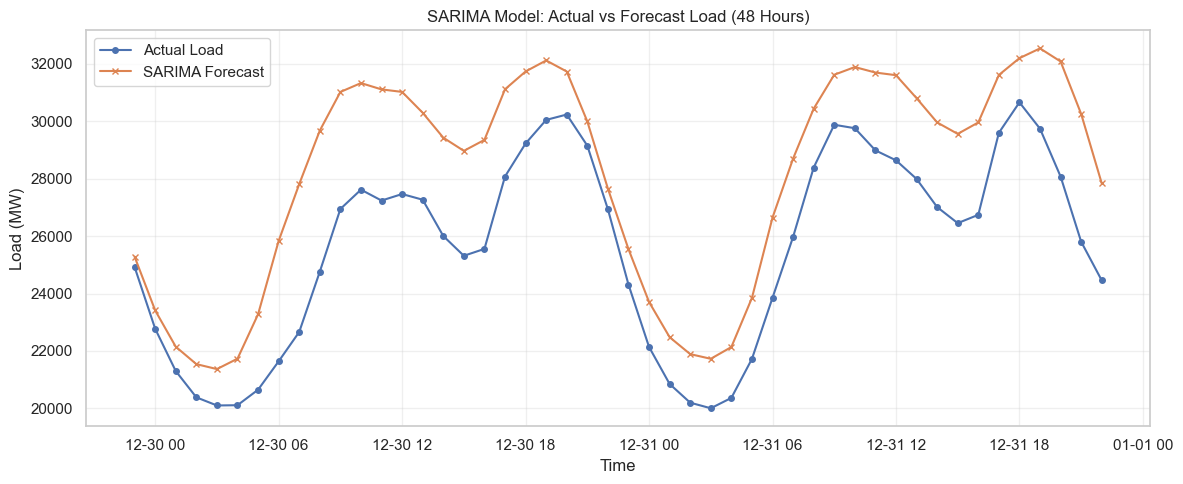

In [93]:
## SARIMA Visualization

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(test_load.index, test_load.values, label='Actual Load', marker='o', markersize=4)
plt.plot(forecast_SARIMA.index, forecast_SARIMA.values, label='SARIMA Forecast', marker='x', markersize=4)
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('SARIMA Model: Actual vs Forecast Load (48 Hours)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [98]:
## SARIMA Model Evaluation

# Calculate performance metrics
mae_sarima = mean_absolute_error(test_load, forecast_SARIMA)
mse_sarima = mean_squared_error(test_load, forecast_SARIMA)
rmse_sarima = np.sqrt(mse_sarima)

print("SARIMA Model Performance:")
print(f"  MAE:  {mae_sarima:.2f} MW")
print(f"  RMSE: {rmse_sarima:.2f} MW")
print(f"  MSE:  {mse_sarima:.2f}")

# Comparison DataFrame
comparison_sarima = pd.DataFrame({
    'Actual': test_load.values,
    'Predicted': forecast_SARIMA.values,
    'Error': forecast_SARIMA.values - test_load.values,
    'Abs_Error': np.abs(forecast_SARIMA.values - test_load.values),
    'Pct_Error': ((forecast_SARIMA.values - test_load.values) / test_load.values * 100)
}, index=test_load.index)

SARIMA Model Performance:
  MAE:  2533.79 MW
  RMSE: 2787.15 MW
  MSE:  7768178.94


In [99]:
print("Actual vs Predicted (first 5 rows):")
print(comparison_sarima.head().to_string())


Actual vs Predicted (first 5 rows):
                            Actual     Predicted        Error    Abs_Error  Pct_Error
timestamp                                                                            
2018-12-29 23:00:00+00:00  24922.0  25280.935051   358.935051   358.935051   1.440234
2018-12-30 00:00:00+00:00  22772.0  23410.901524   638.901524   638.901524   2.805645
2018-12-30 01:00:00+00:00  21301.0  22147.989901   846.989901   846.989901   3.976292
2018-12-30 02:00:00+00:00  20386.0  21541.998095  1155.998095  1155.998095   5.670549
2018-12-30 03:00:00+00:00  20103.0  21369.729898  1266.729898  1266.729898   6.301198


In [100]:
print("Error Statistics:")
print(f"  Mean Error: {comparison_sarima['Error'].mean():.2f} MW")
print(f"  Mean Absolute Error: {comparison_sarima['Abs_Error'].mean():.2f} MW")
print(f"  Mean Absolute Percentage Error: {comparison_sarima['Pct_Error'].abs().mean():.2f}%")
print(f"  Max Overprediction: {comparison_sarima['Error'].max():.2f} MW")
print(f"  Max Underprediction: {comparison_sarima['Error'].min():.2f} MW")


Error Statistics:
  Mean Error: 2533.79 MW
  Mean Absolute Error: 2533.79 MW
  Mean Absolute Percentage Error: 9.95%
  Max Overprediction: 5146.16 MW
  Max Underprediction: 358.94 MW


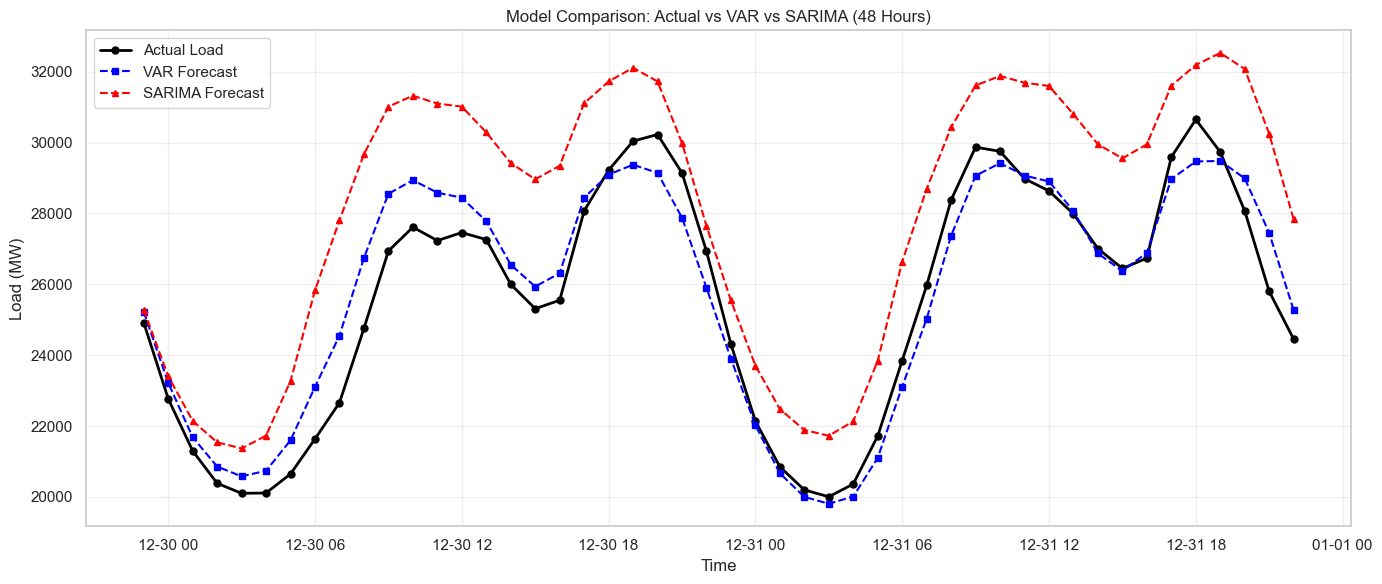

In [102]:
## Visual Comparison of Both Models

# Plot actual vs both forecasts
plt.figure(figsize=(14, 6))
plt.plot(test_load.index, test_load.values, label='Actual Load', 
         color='black', linewidth=2, marker='o', markersize=5)
plt.plot(forecast_VAR.index, forecast_VAR.values, label='VAR Forecast', 
         color='blue', linestyle='--', marker='s', markersize=4)
plt.plot(forecast_SARIMA.index, forecast_SARIMA.values, label='SARIMA Forecast', 
         color='red', linestyle='--', marker='^', markersize=4)
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.title('Model Comparison: Actual vs VAR vs SARIMA (48 Hours)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

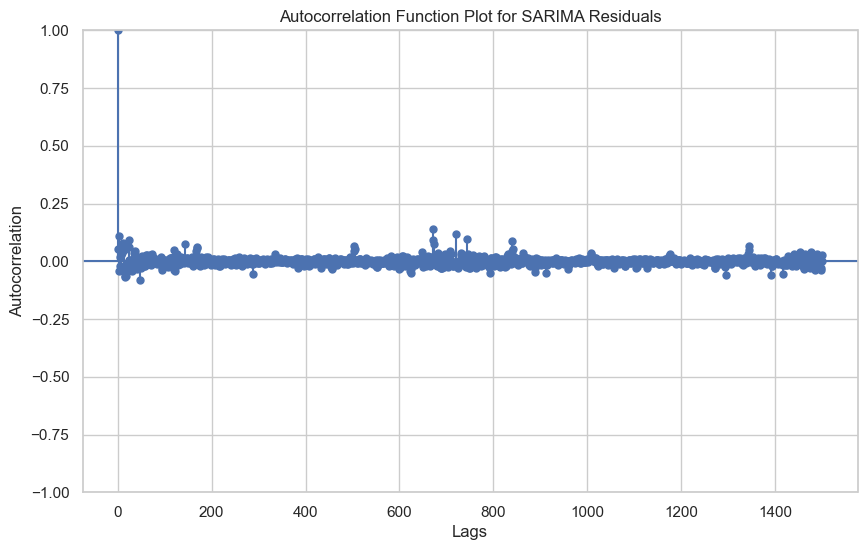

In [105]:
# Plot SARIMA model residuals
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(best_sarima_model.resid, lags=1500, alpha=0.05, ax=ax)
ax.set_title('Autocorrelation Function Plot for SARIMA Residuals')
ax.set_xlabel('Lags')
ax.set_ylabel('Autocorrelation')
plt.show()